<a href="https://colab.research.google.com/github/NaveenSuresh07/Telemetry-Anomaly-Detection-/blob/main/Telemetry_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Install Kaggle library
!pip install -q kaggle

# 2. Upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 3. Setup Kaggle directory permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download and Unzip NASA SMAP Dataset
!kaggle datasets download -d patrickfleith/nasa-anomaly-detection-dataset-smap-msl
!mkdir -p data_temp
!unzip -q nasa-anomaly-detection-dataset-smap-msl.zip -d data_temp

# 5. Fix Folder Structure: Move files to 'data/train' and 'data/test'
import os
import shutil
!mkdir -p data/train data/test

for root, dirs, files_list in os.walk('/content/data_temp'):
    if 'train' in dirs:
        for f in os.listdir(os.path.join(root, 'train')):
            shutil.move(os.path.join(root, 'train', f), 'data/train/')
    if 'test' in dirs:
        for f in os.listdir(os.path.join(root, 'test')):
            shutil.move(os.path.join(root, 'test', f), 'data/test/')

print("✅ Data setup complete. Files are ready in /content/data/!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/patrickfleith/nasa-anomaly-detection-dataset-smap-msl
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.73GB/s]
✅ Data setup complete. Files are ready in /content/data/!


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load one telemetry channel (P-1 is a standard power channel)
train_raw = np.load('data/train/P-1.npy')
test_raw = np.load('data/test/P-1.npy')

# 1. Normalize data (0 to 1 range)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled = scaler.transform(test_raw)

# 2. Create Time-Series Sequences
def create_sequences(data, window_size=50):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

X_train = create_sequences(train_scaled)
X_test = create_sequences(test_scaled)

print(f"Input Data Shape: {X_train.shape}") # Should be (samples, 50, 1)

Input Data Shape: (2822, 50, 25)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input
from tensorflow.keras import backend as K

# 1. Clear memory and set dimensions
K.clear_session()
window_size = 50
n_features = 25  # We change this from 1 to 25 to match your data!

# 2. Build the Multi-Variable Model
model = Sequential([
    # Now expecting 50 timestamps and 25 features
    Input(shape=(window_size, n_features)),

    # Encoder
    LSTM(64, activation='relu', return_sequences=False),

    # Repeat the compressed "summary" 50 times
    RepeatVector(window_size),

    # Decoder
    LSTM(64, activation='relu', return_sequences=True),

    # Output layer must produce 25 values (one for each channel)
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mae')
model.summary()

# 3. Start Training
# This will now work because X_train (..., 50, 25) matches model (..., 50, 25)
history = model.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,689 (225.35 KB)

 Trainable params: 57,689 (225.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0316 - val_loss: 0.0313
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0268 - val_loss: 0.0310
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - val_loss: 0.0309
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0261 - val_loss: 0.0309
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - val_loss: 0.0308
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0258 - val_loss: 0.0308
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0253 - val_loss: 0.0307
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0264 - val_loss: 0.0307
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0258 - val_loss: 0.0307
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0259 - val_loss: 0.0307
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0260 - val_loss: 0.0307
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0

89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Reconstruction error threshold: 0.0689203326881368


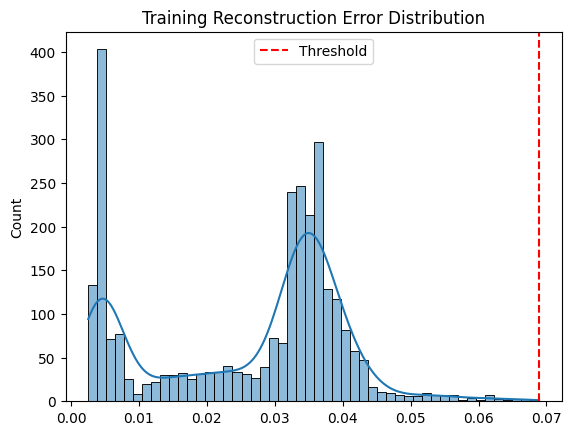

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the reconstruction on training data
X_train_pred = model.predict(X_train)

# 2. Calculate Mean Absolute Error (MAE) across all 25 channels
# This gives us one 'error score' for every 50-minute window
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))

# 3. Set the threshold (The max error seen on 'Normal' data)
threshold = np.max(train_mae_loss)
print(f"Reconstruction error threshold: {threshold}")

# 4. Visualize the Error Distribution
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Training Reconstruction Error Distribution")
plt.legend()
plt.show()

In [11]:
# 1. Prepare Test Data (Same sliding window as X_train)
X_test = create_sequences_fixed(test_scaled, window_size)

# 2. Predict/Reconstruct
X_test_pred = model.predict(X_test)

# 3. Calculate MAE for Test Data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# 4. Identify windows where error > threshold
anomalies = test_mae_loss > threshold
print(f"Number of anomaly windows detected: {np.sum(anomalies)}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Number of anomaly windows detected: 8


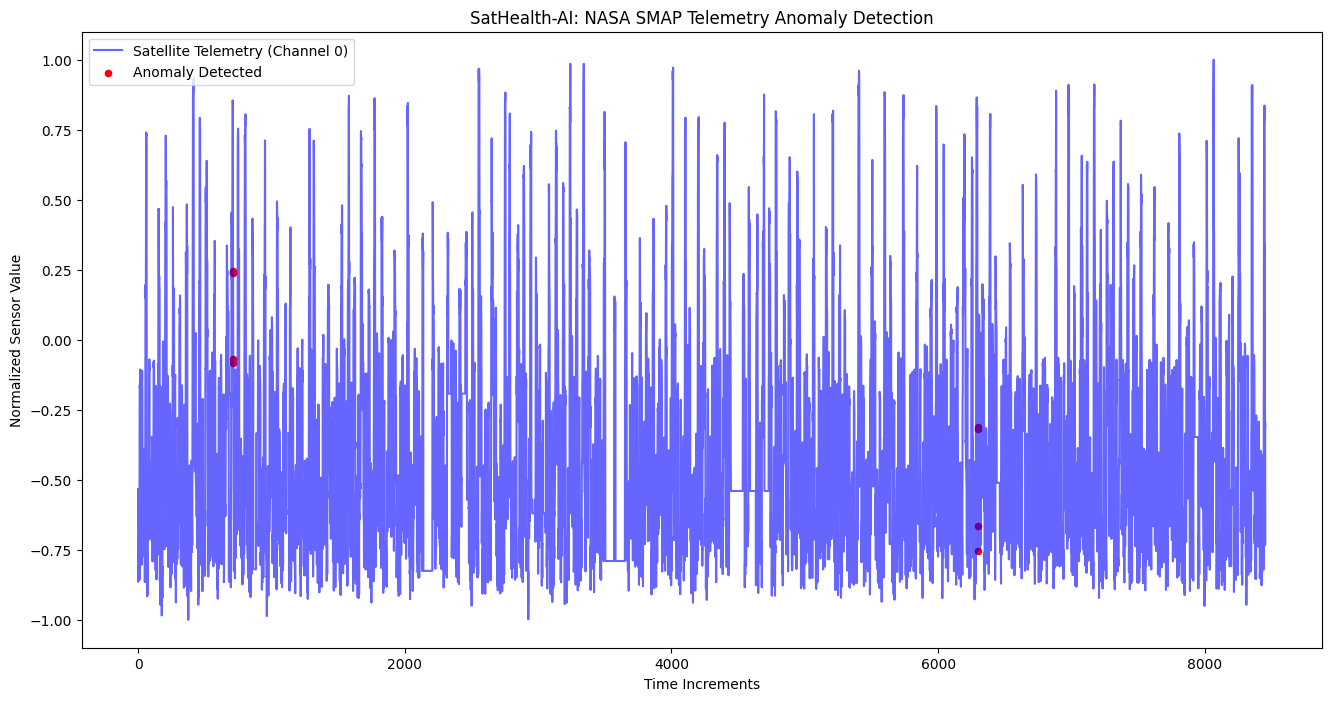

In [12]:
# Create a plot for a specific telemetry channel
plt.figure(figsize=(16, 8))

# Plot the actual values (we use the raw test data)
# We shift by window_size because the first prediction starts after the first window
plt.plot(test_raw[window_size:, 0], label='Satellite Telemetry (Channel 0)', color='blue', alpha=0.6)

# Overlay anomalies
anomaly_indices = np.where(anomalies)[0]
anomaly_values = test_raw[window_size:][anomalies, 0]
plt.scatter(anomaly_indices, anomaly_values, color='red', label='Anomaly Detected', s=20)

plt.title("SatHealth-AI: NASA SMAP Telemetry Anomaly Detection")
plt.xlabel("Time Increments")
plt.ylabel("Normalized Sensor Value")
plt.legend()
plt.show()

In [13]:
plt.savefig('results.png')

<Figure size 640x480 with 0 Axes>